Data from Holman et al 2021

[Animals, protists and bacteria share marine biogeographic patterns](https://www.nature.com/articles/s41559-021-01439-7#Sec8)

[Data from Zenodo](https://zenodo.org/records/4564075)

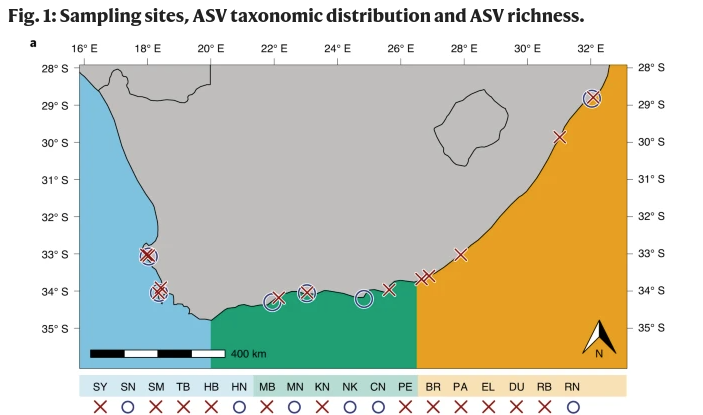

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import shutil

from collections import Counter
from itertools import combinations
from scipy.stats import entropy

import BCI

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read the asv table

First column of the asv table should be the name of the asvs which should match exactly the names of the
asvs in the fasta file

In [4]:
asv_table = "./_zenodo_data/rawdata/COI_DADA.csv"
# Removing unused samples from the asv table
cleaned_asv_table = "./asv_table-cleaned.csv"
fasta_data = "./_zenodo_data/rawdata/DADA2.COI.OTUs.gz"
# We will create this next file after loading the asv_table
sitemap = './sitemap.txt'

metadata = pd.read_csv(asv_table, index_col=0)
metadata

,L.AQ1,L.BR1,L.BR2,L.BR3,L.C1,L.C2,L.C3,L.C4,L.C5,L.C6,L.C7,L.C8,L.C9,L.CN1,L.CN2,L.CN3,L.DC1,L.DC2,L.DC3,L.DU1,L.DU2,L.DU3,L.EL1,L.EL2,L.EL3,L.HB1,L.HB2,L.HB3,L.HN1,L.HN2,L.HN3,L.KN1,L.KN2,L.KN3,L.MB1,L.MB2,L.MB3,L.MN1,L.MN2,L.MN3,L.NK1,L.NK2,L.NK3,L.PA1,L.PA2,L.PA3,L.PCR1,L.PE1,L.PE2,L.PE3,L.RB1,L.RB2,L.RB3,L.RN1,L.RN2,L.RN3,L.SM1,L.SM2,L.SM3,L.SN1,L.SN2,L.SN3,L.SY1,L.SY2,L.SY3,L.TB1,L.TB2,L.TB3,Unnamed: 69
OTUID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
OTU_1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10557,13553,21689,22858,40972,30060,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,37929,47834,22757,25940,27125,24402,17105,25596,36467,0,8,0,NaN
OTU_10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14619,18671,29087,7817,14340,10318,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42,140,40,NaN
OTU_100,0,121,110,100,0,0,0,0,0,0,0,0,0,607,963,736,0,0,0,0,0,0,0,0,0,61,51,140,522,940,616,209,278,176,345,212,253,497,419,443,512,843,890,64,101,91,0,52,92,61,0,0,0,0,0,0,39,56,27,68,75,52,14,17,34,331,1163,201,NaN
OTU_1000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,5,0,0,14,9,270,212,232,122,107,103,21,38,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
OTU_10000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OTU_9995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,3,4,0,NaN
OTU_9996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0,0,0,0,NaN
OTU_9997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,8,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN


In [5]:
# Remove control, other, and unidentified sites
drop_cols = ["L.C1", "L.C2", "L.C3", "L.C4", "L.C5", "L.C6", "L.C7", "L.C8", "L.C9",
            "L.PCR1", "Unnamed: 69", "L.DC1", "L.DC2", "L.DC3", "L.AQ1"]
metadata = metadata.drop(columns=drop_cols)
metadata.to_csv(cleaned_asv_table)
metadata

,L.BR1,L.BR2,L.BR3,L.CN1,L.CN2,L.CN3,L.DU1,L.DU2,L.DU3,L.EL1,L.EL2,L.EL3,L.HB1,L.HB2,L.HB3,L.HN1,L.HN2,L.HN3,L.KN1,L.KN2,L.KN3,L.MB1,L.MB2,L.MB3,L.MN1,L.MN2,L.MN3,L.NK1,L.NK2,L.NK3,L.PA1,L.PA2,L.PA3,L.PE1,L.PE2,L.PE3,L.RB1,L.RB2,L.RB3,L.RN1,L.RN2,L.RN3,L.SM1,L.SM2,L.SM3,L.SN1,L.SN2,L.SN3,L.SY1,L.SY2,L.SY3,L.TB1,L.TB2,L.TB3
OTUID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
OTU_1,0,0,0,0,0,0,0,0,0,0,0,0,10557,13553,21689,22858,40972,30060,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,37929,47834,22757,25940,27125,24402,17105,25596,36467,0,8,0
OTU_10,0,0,0,0,0,0,0,0,0,0,0,0,14619,18671,29087,7817,14340,10318,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42,140,40
OTU_100,121,110,100,607,963,736,0,0,0,0,0,0,61,51,140,522,940,616,209,278,176,345,212,253,497,419,443,512,843,890,64,101,91,52,92,61,0,0,0,0,0,0,39,56,27,68,75,52,14,17,34,331,1163,201
OTU_1000,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,5,0,0,14,9,270,212,232,122,107,103,21,38,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
OTU_10000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OTU_9995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,3,4,0
OTU_9996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0,0,0,0
OTU_9997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,8,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Create sitemap file

Sitemap file is formatted like this:

    sample1    site1
    sample2    site1
    sample3    site2
    sample4    site2
    ...
    samplen    siten


In [6]:
# In the metadata remove the 'L.' and trailing integer to isolate site codes
sites = list(set([x[2:-1] for x in metadata.columns]))
print(len(sites), sorted(sites))

with open(sitemap, 'w') as outfile:
    outfile.write("#sample\tsite\n")
    for site in sites:
        sids = [x for x in metadata.columns if site in x]
        for sid in sids:
            outfile.write(f"{sid}\t{site}\n")


18 ['BR', 'CN', 'DU', 'EL', 'HB', 'HN', 'KN', 'MB', 'MN', 'NK', 'PA', 'PE', 'RB', 'RN', 'SM', 'SN', 'SY', 'TB']


## Load the data into a BCI project

In [9]:
pjt = BCI.Project(cleaned_asv_table, fasta_data, sitemap)


In [ ]:
pjt.run(samples=False, verbose=True)

  Processing 18 sites.
BR
[627, 571, 543, 521, 502, 492, 477, 469, 461, 455, 445, 429, 419, 403, 381, 361, 331, 314, 285, 264, 242, 210, 193, 175, 150, 134, 119, 104, 88, 84]
CN
[1999, 1818, 1699, 1639, 1582, 1539, 1502, 1464, 1431, 1406, 1358, 1313, 1259, 1204, 1138, 1070, 968, 876, 817, 733, 662, 589, 527, 470, 395, 354, 299, 246, 217, 178]
DU
[783, 748, 713, 690, 662, 645, 633, 621, 610, 601, 588, 574, 561, 541, 508, 483, 443, 414, 377, 341, 325, 280, 260, 238, 202, 180, 157, 141, 115, 95]
EL
[1057, 969, 916, 880, 846, 830, 817, 799, 779, 760, 746, 720, 695, 668, 631, 587, 542, 506, 457, 426, 393, 355, 308, 271, 238, 212, 185, 152, 134, 113]
HB


In [ ]:
cmaps = {"Blues":["SN", "HN", "MN", "NK", "CN", "RN"],
         "Reds":["BR", "DU", "EL", "HB", "KN", "MB", "PA", "PE", "RB", "SM", "SY", "TB"]}
pjt.plot_sites(plot_pis=True, cmaps=cmaps)

# Run a subset of sites retaining intact and disturbed pairs

In [68]:
subset = ["SY", "SN", "HB", "HN", "MB", "MN", "RB", "RN"]
pjt.run(samples=False, sites=subset)

  Processing 8 sites.


(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

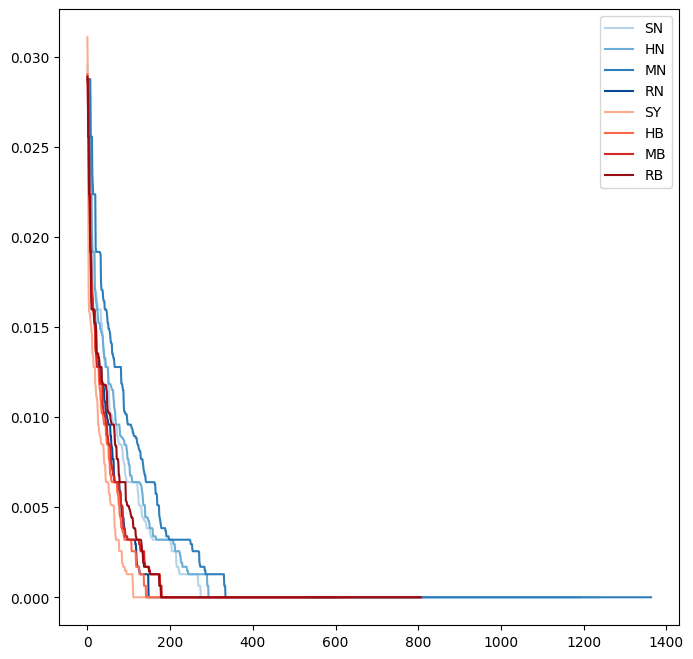

In [69]:
cmaps = {"Blues":["SN", "HN", "MN", "RN"],
         "Reds":["SY", "HB", "MB", "RB"]}
pjt.plot_sites(plot_pis=True, cmaps=cmaps)

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

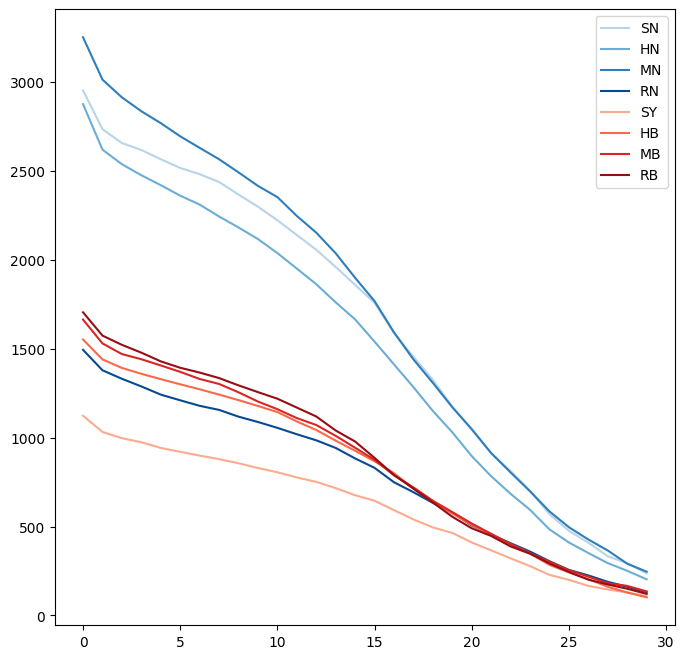

In [70]:
pjt.plot_sites(cmaps=cmaps)

# Resample ASVs to a level that is close to the minimum

In [58]:
subset = ["SY", "SN", "HB", "HN", "MB", "MN", "RB", "RN"]
pjt.run(samples=False, sites=subset, resample=2600)

  Processing 8 sites.
SY
  Wrote transformed data to: ./.tmpdir-SY/SY-resa-2600.fasta
[948, 882, 852, 830, 804, 782, 769, 750, 731, 708, 689, 663, 645, 614, 585, 553, 509, 465, 429, 393, 347, 319, 276, 244, 204, 179, 148, 127, 114, 96]
SN
  Wrote transformed data to: ./.tmpdir-SN/SN-resa-2600.fasta
[1958, 1864, 1834, 1809, 1778, 1746, 1727, 1694, 1661, 1620, 1572, 1515, 1458, 1374, 1303, 1222, 1114, 1018, 934, 837, 756, 660, 576, 508, 434, 371, 307, 250, 207, 173]
HB
  Wrote transformed data to: ./.tmpdir-HB/HB-resa-2600.fasta
[1542, 1432, 1384, 1352, 1324, 1294, 1267, 1238, 1206, 1175, 1138, 1088, 1038, 980, 923, 863, 795, 710, 634, 570, 506, 448, 397, 347, 282, 240, 203, 161, 128, 102]
HN
  Wrote transformed data to: ./.tmpdir-HN/HN-resa-2600.fasta
[1921, 1796, 1746, 1714, 1671, 1639, 1613, 1574, 1524, 1487, 1435, 1375, 1320, 1250, 1180, 1113, 997, 903, 824, 738, 645, 570, 513, 447, 361, 314, 269, 231, 187, 155]
MB
  Wrote transformed data to: ./.tmpdir-MB/MB-resa-2600.fasta
[1541, 1

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

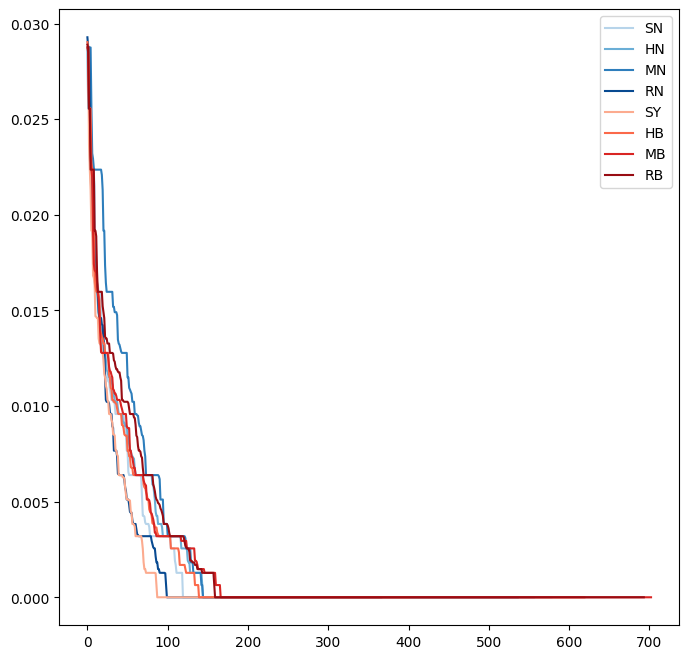

In [62]:
cmaps = {"Blues":["SN", "HN", "MN", "RN"],
         "Reds":["SY", "HB", "MB", "RB"]}
pjt.plot_sites(plot_pis=True, cmaps=cmaps)

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

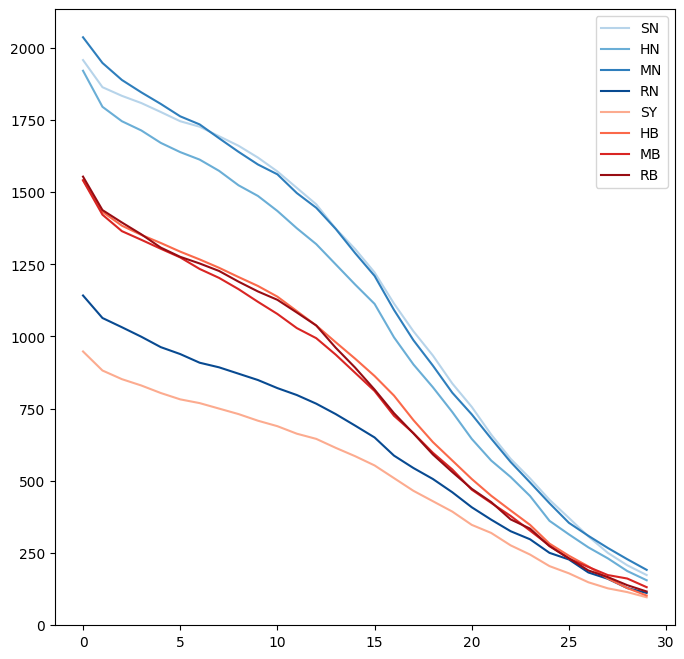

In [67]:
cmaps = {"Blues":["SN", "HN", "MN", "RN"],
         "Reds":["SY", "HB", "MB", "RB"]}
pjt.plot_sites(cmaps=cmaps)

# Run the sites

In [ ]:
pjt.run(samples=True, sites=False, verbose=True)

# Junk below here